# Lab 5 - Embedding Adaptors

In [1]:
import os
import chromadb
import openai
from helper_utils import word_wrap, project_embeddings
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
import numpy as np
import umap
from tqdm import tqdm

import torch
import torch_directml
device = torch_directml.device()
print(f"Using device: {device}")

Using device: privateuseone:0


In [2]:

openai_api_key = os.environ['OPENAI_API_KEY']
embedding_function = OpenAIEmbeddingFunction(api_key=openai_api_key, model_name="text-embedding-3-small")

chroma_collection = chromadb.PersistentClient('microsoft_annual_report_2022').create_collection(
    "microsoft_annual_report_2022", 
    embedding_function=embedding_function,
    get_or_create=True)

chroma_collection.count()

307

In [3]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/rares/proj/notebook/adv-retrieval-w-chroma/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 307/307 [00:05<00:00, 55.66it/s] 


In [4]:
openai_client = openai.OpenAI()

## Creating a dataset

In [5]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [6]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. What is the company's revenue trend over the past few years?
2. How does the company's net profit margin compare to its competitors in the industry?
3. What is the company's current debt level and how has it changed from the previous year?
4. What are the key drivers behind the changes in the company's operating expenses?
5. How efficient is the company in managing its inventory turnover?
6. What is the company's dividend history and policy?
7. How does the company's return on equity (ROE) compare to industry averages?
8. What are the risks highlighted by the company in the annual report?
9. How has the company's cash flow from operations trended over the past few years?
10. What is the breakdown of the company's revenues by product segment or geographical region?
11. How has the company's market share changed over the past year?
12. What are the company's major long-term liabilities and commitments?
13. What is the company's capital expenditure plan for the upcoming year?
14. How d

In [7]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [8]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [9]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [10]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [11]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:00<00:00,  4.07s/it]


In [12]:
len(adapter_labels)

150

In [13]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings)).to(device)
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings)).to(device)
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1)).to(device)

In [14]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## Setting up the model

In [15]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)


In [16]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [17]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, device=device, requires_grad=True)

In [19]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.detach().cpu().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()


100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


In [ ]:
print(f"Best loss: {float(min_loss.cpu() if torch.is_tensor(min_loss) else min_loss)}")

Best loss: 0.7860766053199768


In [ ]:
test_vector = torch.ones((mat_size,1), device=device)
scaled_vector = np.matmul(best_matrix, test_vector.cpu().numpy())

/tmp/ipykernel_178247/3796843811.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scaled_vector = np.matmul(best_matrix, test_vector).numpy()


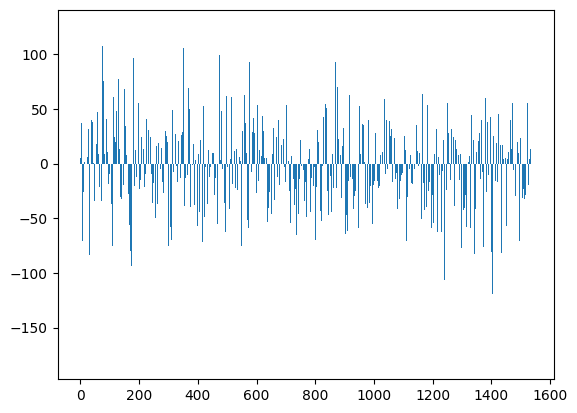

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


In [ ]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:00<00:00, 182.09it/s]


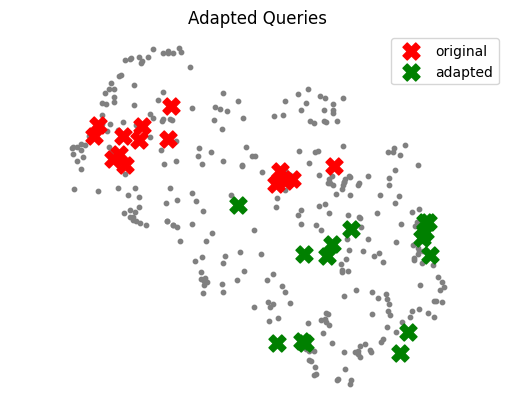

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()